In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\user\AppData\Local\Temp\ipykernel_20672\1018955272.py:11: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(
C:\Users\user\AppData\Local\Temp\ipykernel_20672\1018955272.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-i

In [2]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1)%n] - 1) for i in range(n)])

def effective_hem(size, J):
    hem = np.zeros((2**size, 2**size))
    for i in range(2**size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1)**int(i) for i in binary]
        hem[i,i] = h(size, J, Z)
    return hem

In [14]:
from scipy.linalg import expm
import random
measurements = 10
delay = np.linspace(0,2*np.pi,measurements)
shots = np.arange(500, 10500, 500)
fid = []
allZ = []
allJ = []
for n in range(2,6):
    ZforN = []
    J = [random.gauss(1, 0.1) for _ in range(n)]
    allJ.append(J)
    for s in shots:
        Z = []
        for t in delay:
            qc = QuantumCircuit(n)
            for i in range(n):
                qc.h(i)

            U = expm((-1j*t)*effective_hem(n,J))
            U = qi.Operator(U)

            qc.unitary(U, [i for i in range(n)])

            for i in range(n):
                qc.h(i)
            qc.measure_all()

            #Simulator
            qcomp = Aer.get_backend("qasm_simulator")
            result = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), shots=s//measurements).result()

            Zi = []
            for i in range(n):
                for outcome, count in result.get_counts().items():
                    plus = [count if outcome[i] == '0' else 0]
                    minus = [count if outcome[i] == '1' else 0]
                    Zi.append((sum(plus) - sum(minus))/sum(result.get_counts().values()))

            Z.append(sum(Zi)/n)
        ZforN.append(Z)
    allZ.append(ZforN)


[0.8918128502142131, 1.1067620372377425]


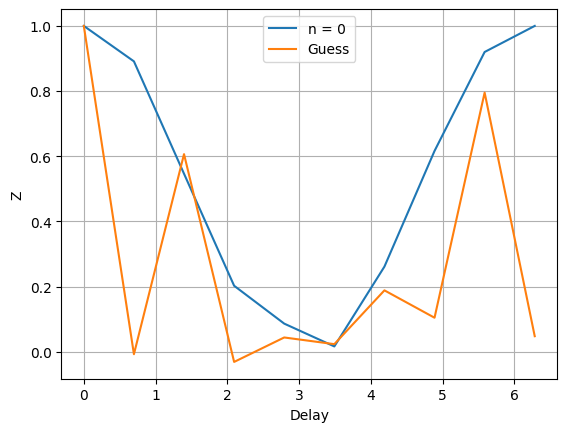

In [39]:
n = 2
n = n-2
def func(J, t):
    n = len(J)
    result = n
    for i in range(n):
        result += 2*np.cos(4 * J[i] * t)
    for i in range(n):
        result += np.cos(4 * (J[i] + J[(i+1)%n]) * t)
    return result/(2*(2*n))
Y = [func(allJ[n],t) for t in delay]
print(allJ[n])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
plt.plot(delay, allZ[n][15], label = f'n = {str(n)}')
plt.plot(delay, Y, label = 'Guess')
plt.legend()

In [37]:
from itertools import permutations
from scipy.optimize import curve_fit
def calc_dist(a,b):
    min_dist = float('inf')
    for perm in permutations(b):
        dist = np.sum([np.abs(ai-bi) for ai, bi in zip(a, perm)])
        if dist < min_dist:
            min_dist = dist
    return min_dist
# def calc_dist(a,b):
#     return np.sqrt(np.sum([np.square(ai-bi) for ai, bi in zip(a, b)]))

#Define the function that you want to fit.
def func(t, *js):
    n = len(js)
    result = n
    for i in range(n):
        result += 2*np.cos(4 * js[i] * t)
    for i in range(n):
        result += np.cos(4 * (js[i] + js[(i+1)%n]) * t)
    return result/(2*(2*n))

fullDist = []
fullGuess = []
for i in range(len(allZ)):
    guesses = []
    dist = []
    for j in range(len(allZ[i])):
        initial_js = np.ones(n)
        try:
            guess, pcov = curve_fit(func, delay, allZ[i][j], p0=initial_js, bounds=(0,2))
        except RuntimeError:
            print(f"Failed to converge for i={i}, j={j}. Skipping...")
            guesses.append(initial_js)
            dist.append(None)
            continue  # Skip to the next iteration
        guesses.append(guess)
        dist.append(calc_dist(guess, allJ[i]))
    fullDist.append(dist)
    fullGuess.append(guesses)

Failed to converge for i=1, j=6. Skipping...


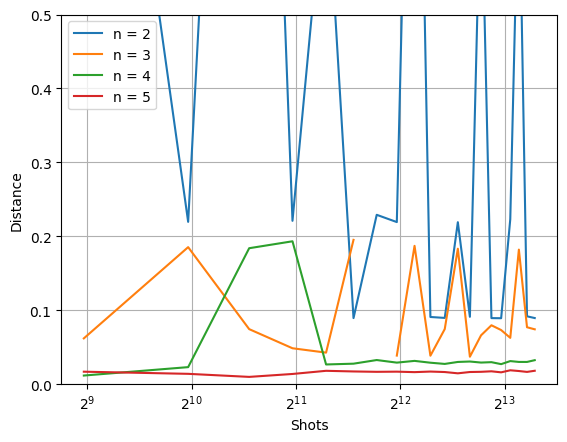

In [40]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
plt.ylim(0,0.5)
for i in range(len(fullDist)):
    dist = fullDist[i]
    plt.plot(shots, dist, label = f'n = {str(i+2)}')
plt.xscale('log', base=2)
plt.legend()
